In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from mlresearch.utils import set_matplotlib_style
from recgame.environments._cda_environment import CDAEnvironment
from recgame.data_augmentation import CDA
from recgame.recourse import DiCE, NFeatureRecourse
from recgame.utils import generate_synthetic_data

In [2]:
set_matplotlib_style(16)

# Some variables to define the problem
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED+1)
N_CONTINUOUS = 2
N_CAT = 0
N_AGENTS = 100

# Environment variables
N_LOANS = 10  # np.array([20, 1, 10, 30, 0, 5, 50, 10, 40])
ADAPTATION = .1  # np.array([.2, .1, .3, .25, .1, .4, .05, .05, .2])
NEW_AGENTS = 10  # np.array([40, 10, 50, 5, 0, 100, 0, 0, 20])

df, y, categorical = generate_synthetic_data(N_AGENTS, N_CONTINUOUS, N_CAT, RNG_SEED)

# model = RandomForestClassifier().fit(df, y)
model = LogisticRegression().fit(df, y)

In [3]:
def data_source_func(n_agents):
    X, _, _ = generate_synthetic_data(
        n_agents=n_agents,
        n_continuous=N_CONTINUOUS,
        n_categorical=N_CAT,
        random_state=rng,
    )
    return X

# CDA experiment

In [4]:
y = (model.predict_proba(df)[:, 1] > .7).astype(int)

recourse = NFeatureRecourse(model, threshold=0.7, categorical=categorical)
CDA(recourse=recourse, ir=1, random_state=42).fit_resample(df, y)

(          f_0       f_1
 0    0.601572  0.153339
 1    0.750150  0.813522
 2   -0.150345  0.065940
 3    0.542613  0.394586
 4    0.494400  0.215652
 ..        ...       ...
 191  1.032781  0.099074
 192  1.022959  0.084240
 193  1.165577  0.299635
 194  0.917010 -0.075773
 195  1.162986  0.295721
 
 [196 rows x 2 columns],
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

# Environment experiment

In [5]:
# Define the necessary components to run simulation
recourse = NFeatureRecourse(model, categorical=categorical)
recourse.set_actions(df)
recourse.action_set_.ub = [2, 2]

environment = CDAEnvironment(
    X=df,
    recourse=recourse,
    data_source_func=data_source_func,
    threshold=N_LOANS,
    threshold_type="absolute",
    adaptation=ADAPTATION,
    behavior_function="binary_constant",
    growth_rate=NEW_AGENTS,
    growth_rate_type="absolute",
    random_state=RNG_SEED,
)

environment.simulate(20)

CDAEnvironment(X=         f_0       f_1
0   0.601572  0.153339
1   0.750150  0.813522
2  -0.150345  0.065940
3   0.542613  0.394586
4   0.494400  0.215652
..       ...       ...
95  1.074555  0.440160
96  0.372271  0.987148
97  0.130985  0.201758
98  0.714442  0.368465
99  0.498293  0.445519

[100 rows x 2 columns],
               adaptation=0.1, behavior_function='binary_constant',
               data_source_func=<function data_source_func at 0x7faae195b640>,
               growth_rate=10, growth_rate_type='absolute', random_state=42,
               recourse=NFeatureRecourse(categorical=[],
                                         model=LogisticRegression(),
                                         threshold=0.6528376515442222),
               threshold=10)

In [6]:
environment.X_, environment.outcome_

from collections import Counter
Counter(environment.outcome_)

Counter({0: 90, 1: 10})

<Axes: title={'center': 'Population scores over 20 time steps'}, xlabel='Step', ylabel='Score'>

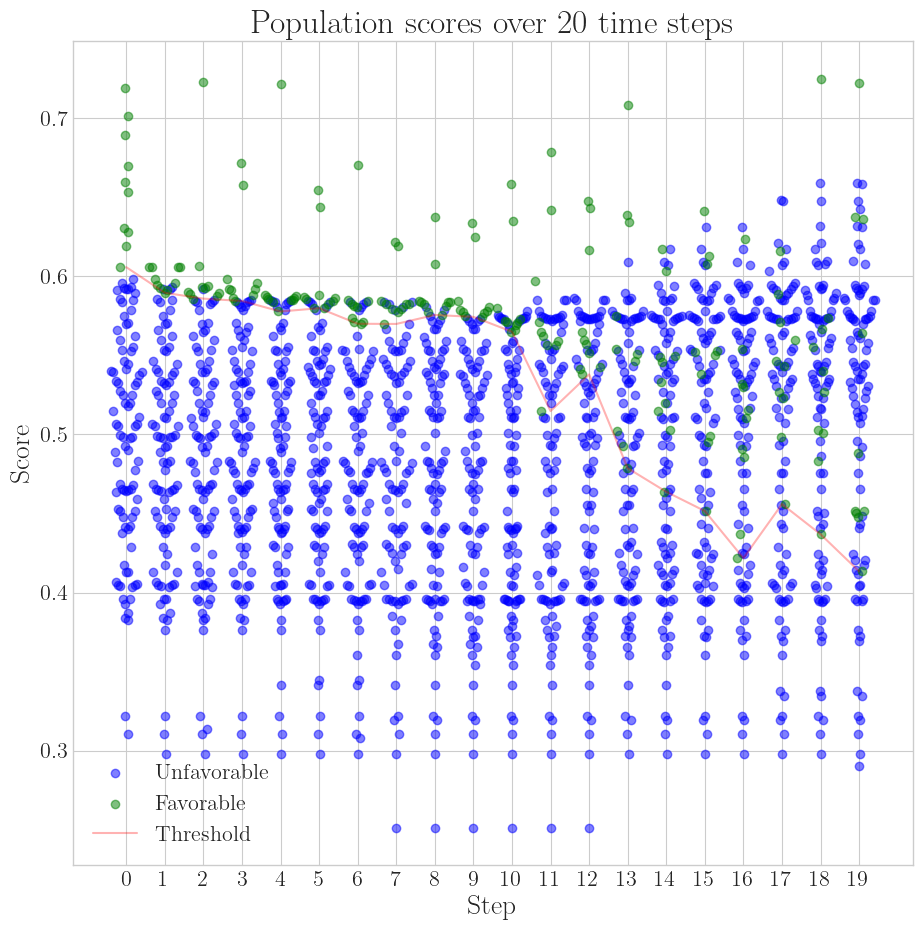

In [7]:
environment.plot.agent_scores(ref_model_step=0)

<Axes: title={'center': 'Population at t=7'}, xlabel='f_0', ylabel='f_1'>

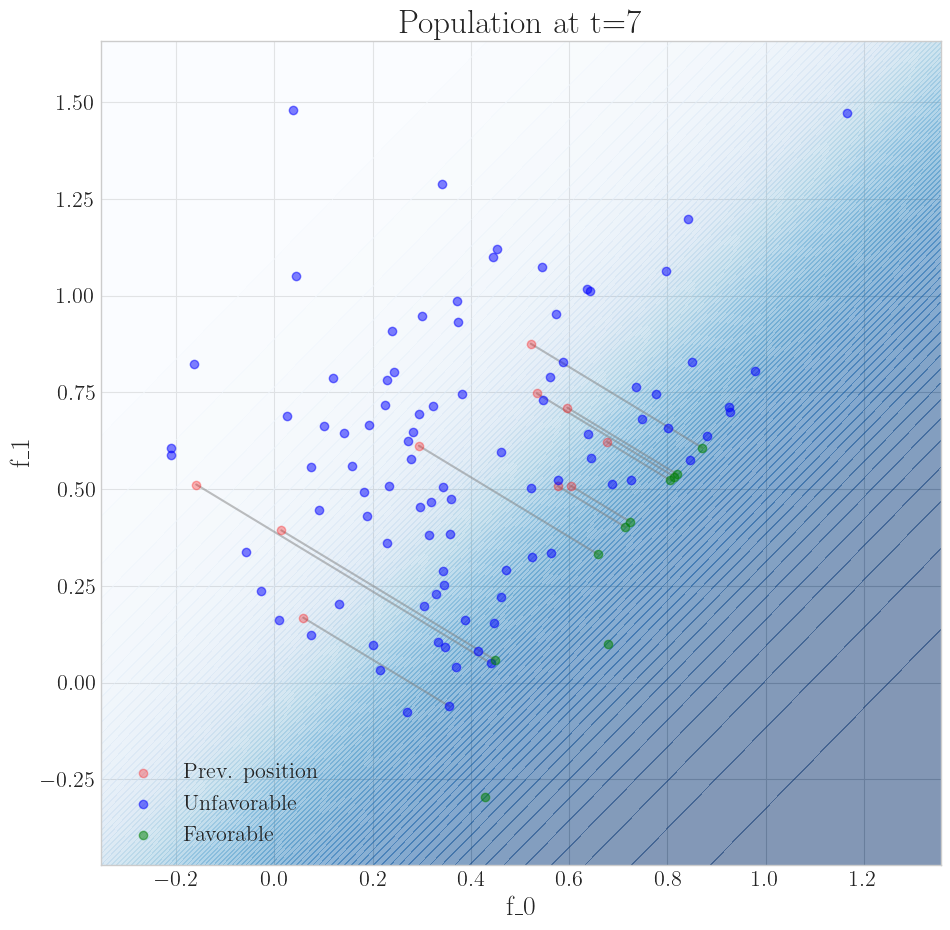

In [8]:
environment.plot.scatter(7)

# Analysis

In [9]:
steps_info = environment.analysis.steps_info()
steps_info

,n_adapted,n_candidates,favorable_outcomes,success_rate,threshold,threshold_drift,new_agents,new_agents_proba,moving_agent_proba,success_proba
1,4.0,3.0,10.0,1.000000,0.638688,0.054424,10.0,0.06,0.111111,0.425635
2,10.0,10.0,10.0,0.700000,0.716355,0.121604,10.0,0.01,0.111111,0.418147
3,10.0,9.0,10.0,0.777778,0.712546,-0.005318,10.0,0.01,0.100000,0.544296
4,9.0,6.0,10.0,0.666667,0.682273,-0.042486,10.0,0.03,0.077778,0.807650
5,7.0,6.0,10.0,1.000000,0.655719,-0.038920,10.0,0.05,0.077778,0.800353
6,7.0,6.0,10.0,1.000000,0.668149,0.018957,10.0,0.04,0.111111,0.388920
7,10.0,8.0,10.0,0.875000,0.706358,0.057185,10.0,0.01,0.088889,0.651689
8,8.0,6.0,10.0,0.666667,0.700479,-0.008323,10.0,0.02,0.100000,0.503360
9,9.0,8.0,10.0,0.500000,0.663609,-0.052635,10.0,0.04,0.155556,0.075308
10,14.0,12.0,10.0,0.416667,0.665645,0.003069,10.0,0.04,0.111111,0.360907


In [10]:
(1 - steps_info["success_rate"]) * steps_info["n_candidates"], ((1 - steps_info["success_rate"]) * steps_info["n_candidates"]).sum()

(1     0.0
 2     3.0
 3     2.0
 4     2.0
 5     0.0
 6     0.0
 7     1.0
 8     2.0
 9     4.0
 10    7.0
 11    5.0
 12    2.0
 13    2.0
 14    5.0
 15    5.0
 16    2.0
 17    7.0
 18    4.0
 19    6.0
 20    6.0
 dtype: float64,
 65.0)

In [14]:
from collections import Counter
Counter(environment.analysis.agents_info().n_failures), environment.analysis.agents_info().n_failures.sum()


(Counter({0: 256, 1: 29, 2: 9, 3: 6}), 65)

In [12]:
environment.analysis.agents_info()

,entered_step,n_adaptations,favorable_step,original_score,final_score,n_failures
0,0,1,2.0,0.592102,0.718428,0
1,0,1,9.0,0.519861,0.715191,0
2,0,1,5.0,0.417626,0.709887,0
3,0,1,2.0,0.537543,0.717446,0
4,0,1,6.0,0.555235,0.669050,0
...,...,...,...,...,...,...
295,20,0,20.0,0.747448,0.747448,0
296,20,0,20.0,0.638435,0.638435,0
297,20,0,NaN,0.125336,NaN,0
298,20,0,20.0,0.886535,0.886535,0
